In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np

In [2]:
# Loads the AMES housing Dataset
housing = fetch_openml(name="house_prices", as_frame=True)  # noqa

In [3]:
data = pd.DataFrame(data= np.c_[housing['data'], housing['target']],
                     columns= housing['feature_names'] + ['target'])

In [4]:
liste_to_numeric = ['YrSold', 'YearBuilt', 'GrLivArea', 'LotFrontage', 'LotArea','GarageArea']
data[liste_to_numeric] = data[liste_to_numeric].apply(pd.to_numeric)


Data cleaning

In [5]:
# create dumies
data['Fence'] = data['Fence'].notna()
data['Pool'] = data['PoolArea'] > 0

# create the new variable 'age'
data['Age'] = data.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 


In [6]:
# Select Features
X = data[['Age','GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea', 'Fence', 'Pool']]
Y = data[['target']]

In [7]:
# Save the clean version
X.to_csv('clean_X.csv', index=False)

In [8]:
X.head()

,Age,GrLivArea,LotFrontage,LotArea,GarageArea,Fence,Pool
0,5.0,1710.0,65.0,8450.0,548.0,False,False
1,31.0,1262.0,80.0,9600.0,460.0,False,False
2,7.0,1786.0,68.0,11250.0,608.0,False,False
4,8.0,2198.0,84.0,14260.0,836.0,False,False
5,16.0,1362.0,85.0,14115.0,480.0,True,False


In [9]:
Y.head()

,target
0,208500.0
1,181500.0
2,223500.0
4,250000.0
5,143000.0


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.3, random_state=1121218)

In [11]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [12]:
numerical_features

['Age', 'GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea']

In [13]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [14]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [15]:
randomf = RandomForestRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

In [19]:
from sklearn.model_selection import GridSearchCV

param_dict = {'model__n_estimators': [50,100,150,200], 'model__bootstrap': [True,False]}

search = GridSearchCV(
    randomf_pipeline, 
    param_dict, 
    cv=10, 
    scoring='neg_mean_absolute_error',
    refit=False,
    return_train_score=True)

_ = search.fit(X_train, np.ravel(y_train))

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

Best score: 24107.785988427517
Best params: {'model__bootstrap': True, 'model__n_estimators': 200}


In [21]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__bootstrap', 'param_model__n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'split5_train_score', 'split6_train_score', 'split7_train_score',
       'split8_train_score', 'split9_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [22]:
cv_results = pd.DataFrame(search.cv_results_)
cols  = [
    "mean_train_score",
    "mean_test_score",
]

results = cv_results[cols]

In [24]:
best = results.sort_values(by="mean_test_score", ascending=False).head(1)

for c in cols:
    print(f"{c}: {abs(round(best[c].values[0], 2))}")

mean_train_score: 9019.16
mean_test_score: 24107.79


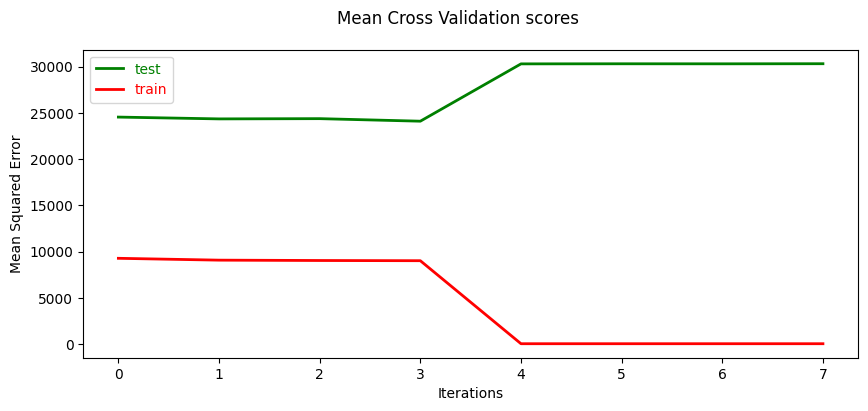

In [27]:

import matplotlib.pyplot as plt

res = pd.DataFrame(search.cv_results_)

# plot lines
with plt.style.context('default'):
    fig = plt.figure(figsize=(10, 4))
    plt.suptitle(f"Mean Cross Validation scores")
    plt.xlabel('Iterations')
    plt.ylabel('Mean Squared Error')
    plt.plot(abs(cv_results["mean_test_score"]), label = "test", lw=2, color="green")
    plt.plot(abs(cv_results["mean_train_score"]), label = "train", lw=2, color="red")
    plt.legend(labelcolor="linecolor")
    plt.show()

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(search, open(filename, 'wb'))